In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

torch.manual_seed(1)

## Get diagosis data

In [2]:
def get_sample_op_claims(sample=1):
    """Returns all outpatient claims for selected sample"""
    df = pd.read_csv(f'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Outpatient_Claims_Sample_{sample}.zip',
                     usecols=['DESYNPUF_ID','CLM_ID','CLM_FROM_DT','PRVDR_NUM','CLM_PMT_AMT',
                               'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
                               'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
                               'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
                               'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
                               'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'ADMTNG_ICD9_DGNS_CD', 'HCPCS_CD_1',
                               'HCPCS_CD_2', 'HCPCS_CD_3', 'HCPCS_CD_4', 'HCPCS_CD_5', 'HCPCS_CD_6',
                               'HCPCS_CD_7', 'HCPCS_CD_8', 'HCPCS_CD_9', 'HCPCS_CD_10', 'HCPCS_CD_11',
                               'HCPCS_CD_12', 'HCPCS_CD_13', 'HCPCS_CD_14', 'HCPCS_CD_15',
                               'HCPCS_CD_16', 'HCPCS_CD_17', 'HCPCS_CD_18', 'HCPCS_CD_19',
                               'HCPCS_CD_20', 'HCPCS_CD_21', 'HCPCS_CD_22', 'HCPCS_CD_23',
                               'HCPCS_CD_24', 'HCPCS_CD_25', 'HCPCS_CD_26', 'HCPCS_CD_27',
                               'HCPCS_CD_28', 'HCPCS_CD_29', 'HCPCS_CD_30', 'HCPCS_CD_31',
                               'HCPCS_CD_32', 'HCPCS_CD_33', 'HCPCS_CD_34', 'HCPCS_CD_35',
                               'HCPCS_CD_36', 'HCPCS_CD_37', 'HCPCS_CD_38', 'HCPCS_CD_39',
                               'HCPCS_CD_40', 'HCPCS_CD_41', 'HCPCS_CD_42', 'HCPCS_CD_43',
                               'HCPCS_CD_44', 'HCPCS_CD_45'
                             ],
                     dtype={'CLM_ID':int,'CLM_PMT_AMT':int},
                     compression='zip',
                     engine='c',
                     parse_dates=['CLM_FROM_DT']
                    )
    return df

In [3]:
%%time
df = get_sample_op_claims(sample=1)
df.shape

/var/folders/td/4jttxk_j59ngw4ck3xdp25th0000gn/T/ipykernel_28936/4017297557.py:3: DtypeWarning: Columns (21,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'https://www.cms.gov/Research-Statistics-Data-and-Systems/Downloadable-Public-Use-Files/SynPUFs/Downloads/DE1_0_2008_to_2010_Outpatient_Claims_Sample_{sample}.zip',


CPU times: user 2.72 s, sys: 390 ms, total: 3.12 s
Wall time: 4.65 s


(790790, 67)

In [4]:
claims_per_member = round(len(df)/len(df['DESYNPUF_ID'].unique()),2)
print(f"{claims_per_member} claims per member on average")

9.27 claims per member on average


In [5]:
# add sort_values(['DESYNPUF_ID','CLM_FROM_DT'])
def get_dx_df(df):
    df_out = df[['DESYNPUF_ID','CLM_FROM_DT',
                 'ICD9_DGNS_CD_1', 'ICD9_DGNS_CD_2', 'ICD9_DGNS_CD_3', 'ICD9_DGNS_CD_4',
                 'ICD9_DGNS_CD_5', 'ICD9_DGNS_CD_6', 'ICD9_DGNS_CD_7', 'ICD9_DGNS_CD_8',
                 'ICD9_DGNS_CD_9', 'ICD9_DGNS_CD_10', 'ICD9_PRCDR_CD_1',
                 'ICD9_PRCDR_CD_2', 'ICD9_PRCDR_CD_3', 'ICD9_PRCDR_CD_4',
                 'ICD9_PRCDR_CD_5', 'ICD9_PRCDR_CD_6', 'ADMTNG_ICD9_DGNS_CD',]
               ].melt(id_vars=['DESYNPUF_ID','CLM_FROM_DT'],
                      value_name='dx'
                     ).drop('variable',axis=1)
    df_out = df_out[df_out['dx'].isna()==False]
    df_out = df_out.drop_duplicates(['DESYNPUF_ID','CLM_FROM_DT','dx']).sort_values(['DESYNPUF_ID','CLM_FROM_DT']).reset_index(drop=True)
    return df_out

In [6]:
dx_df = get_dx_df(df)

In [7]:
dx_df.shape

(2250334, 3)

In [8]:
#dx_df = dx_df.head(2000)
dx_df = dx_df.head(100000)

In [9]:
dx_df.head(20)

,DESYNPUF_ID,CLM_FROM_DT,dx
0,00013D2EFD8E45D1,2008-09-04,V5841
1,00013D2EFD8E45D1,2008-09-04,V5883
2,00016F745862898F,2009-06-02,V5832
3,00016F745862898F,2009-06-02,V5861
4,00016F745862898F,2009-06-02,2724
5,00016F745862898F,2009-06-02,3182
6,00016F745862898F,2009-06-02,V5869
7,00016F745862898F,2009-06-02,42731
8,00016F745862898F,2009-06-23,9594
9,00016F745862898F,2009-06-23,E9174


# Dx dict

In [10]:
vocab = set(dx_df['dx'])
vocab.add('[blank]')
dx_to_ix = {dx: i for i, dx in enumerate(vocab)}

In [11]:
len(vocab)

7076

In [12]:
dx_df['dx'] = [dx_to_ix[x] for x in dx_df['dx']]

In [13]:
class DXDataset(torch.utils.data.Dataset):
    def __init__(self, df, ID_col, context_size, dx_to_ix, mode='CBOW'):
        self.data = df
        self.ID_col = ID_col
        self.context_size=context_size
        self.dx_to_ix = dx_to_ix
        self.mode = mode
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        member = dx_df[self.ID_col].iloc[idx]
        df1 = dx_df[dx_df[self.ID_col] == member].copy()
        self.df1 = df1
        
        if self.mode == 'CBOW':
            if idx >= df1.index.min():
                start = idx - self.context_size//2
            else:
                start = df1.index.min()
            end = idx + self.context_size//2
            
            ngrams_pre = [x for x in df1['dx'].loc[start:(idx-1)]]
            ngrams_post = [x for x in df1['dx'].loc[idx+1:end]]
            ngrams_pre.extend(ngrams_post)
            
            ngrams = [ngrams_pre,
                      df1['dx'].loc[idx]
                     ]
        elif self.mode == 'lead':
            if idx >= df1.index.min():
                start = idx - self.context_size
            else:
                start = df1.index.min()
            
            ngrams = [[x for x in df1['dx'].loc[start:(idx-1)]],
                      df1['dx'].loc[idx]
                     ]
            
            
        if len(ngrams[0]) == 0:
            ngrams[0] = [dx_to_ix['[blank]'] for x in range(self.context_size)]
        elif len(ngrams[0]) < self.context_size:
            size_ = self.context_size - len(ngrams[0])
            for x in range(size_):
                ngrams[0].insert(0, dx_to_ix['[blank]'])
        else:
            pass
        ngrams[0] = torch.tensor(ngrams[0]).unsqueeze(0)
        ngrams[1] = torch.tensor(ngrams[1])
        return ngrams

## Define Model

In [14]:
class NGramICDModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramICDModeler, self).__init__()
        self.vocab_size = vocab_size
        self.context_size = context_size
        self.embedding_dim = embedding_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)
        
    def forward(self, inputs):
        batch_size = inputs.size(0)
        embeds = self.embeddings(inputs).view(batch_size, 1, self.context_size*self.embedding_dim)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=0).view(batch_size, self.vocab_size)
        return log_probs

## Define Training Loop

In [15]:
def training_loop(epochs, training_generator, model, loss_function, device, verbose=True):
    losses = []
    model = model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        for i, data in enumerate(training_generator):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.zero_grad()
            outputs = model(inputs)
            
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        losses.append(total_loss)
        if verbose == True:
            if epoch % 1 == 0:
                print(f"Epoch: {epoch} --- Loss: {round(total_loss, 2)}")
    return model, losses

## Train Model

In [16]:
device = torch.device("mps")
#device = "cpu"

In [17]:
vocab_size = len(vocab)
EMBEDDING_DIM = 100
CONTEXT_SIZE = 10

loss_function = nn.NLLLoss() # include weight= [(1/prevalance of given class) for each class]
model = NGramICDModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
#model = nn.DataParallel(model)
model = model.to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
data = DXDataset(df=dx_df,
                 ID_col='DESYNPUF_ID',
                 context_size=CONTEXT_SIZE,
                 dx_to_ix=dx_to_ix,
                 mode='CBOW')

training_generator = torch.utils.data.DataLoader(data,
                                                 batch_size=128,
                                                 shuffle=True,
                                                 num_workers=8,
                                                 #pin_memory=True,
                                                 #pin_memory_device=device,
                                                 multiprocessing_context='fork' #'fork' or 'spawn'
                                                )

In [19]:
%%time
model, losses = training_loop(20,
                              training_generator,
                              model,
                              loss_function,
                              device=device)

Epoch: 0 --- Loss: 3774.29


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 1 --- Loss: 3459.28


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 2 --- Loss: 2878.09


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 3 --- Loss: 2411.38


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 4 --- Loss: 2147.79


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 5 --- Loss: 1974.02


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 6 --- Loss: 1843.1


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 7 --- Loss: 1733.55


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 8 --- Loss: 1644.28


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 9 --- Loss: 1562.53


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 10 --- Loss: 1491.32


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 11 --- Loss: 1424.4


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 12 --- Loss: 1366.45


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 13 --- Loss: 1308.28


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 14 --- Loss: 1257.31


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 15 --- Loss: 1207.07


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 16 --- Loss: 1162.63


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 17 --- Loss: 1117.12


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 18 --- Loss: 1076.85


[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:229] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Epoch: 19 --- Loss: 1040.7
CPU times: user 1min 10s, sys: 34.3 s, total: 1min 45s
Wall time: 13min 26s


- CPU Only - 1min 2s
- CPU DataParallel - 1min 4s
- GPU Only - 56.1s
- GPU DataParallel - 56.8s

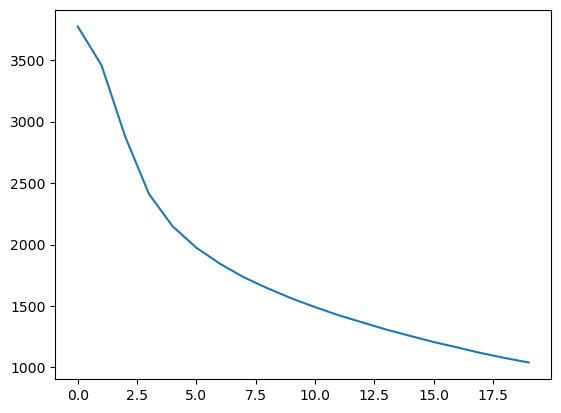

In [20]:
plt.plot(losses)
plt.show()

In [ ]:
#torch.save(model.state_dict(), f"models/test_icd_cbow.pt")

#### Notes:
- May want to incorporate parallelism - can [DataParallel](https://pytorch.org/tutorials/beginner/former_torchies/parallelism_tutorial.html#part-of-the-model-on-cpu-and-part-on-the-gpu) allow multi-core parallel training on single GPU? or only multiple GPUs?